In [10]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

In [11]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = '/home/WUR/janss254/orcestra/data'

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
era5 = cat.HERA5(time="P1D").to_dask()
era5

/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 2TB
Dimensions:    (time: 4991, cell: 196608, level: 29, crs: 1)
Coordinates:
  * crs        (crs) float64 8B nan
    latitude   (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * level      (level) int64 232B 50 70 100 125 150 175 ... 900 925 950 975 1000
    longitude  (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * time       (time) datetime64[ns] 40kB 2010-01-01T12:00:00 ... 2023-08-31T...
Dimensions without coordinates: cell
Data variables: (12/72)
    100u       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    100v       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10u        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10v        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2d         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2t         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    ...         ...
    isor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    lsm        (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdfor      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    slor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    z_sfc      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
Attributes:
    acknowledgment:  Contains modified Copernicus Climate Change Service info...
    contact:         lukas.kluft@mpimet.mpg.de
    creator:         Lukas Kluft
    description:     Selected variables from ERA5, restructured and saved on ...
    institution:     Max Planck Institute for Meteorology
    source:          Post-processed dataset based on the ERA5 mirror located ...
    title:           HERA5 - HEALPixelation of ERA5

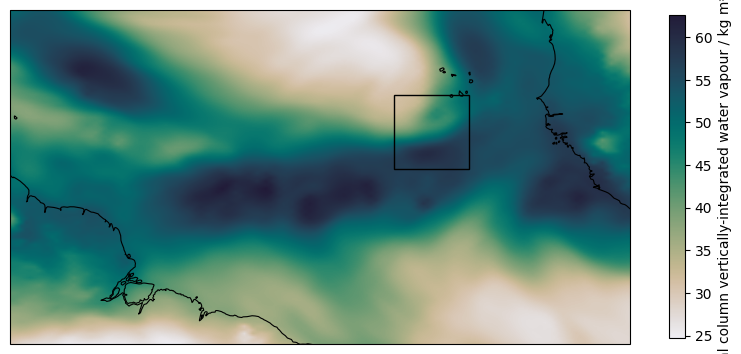

In [3]:
# Selecting the orcestra region and time
# (from https://orcestra-campaign.org/hera5.html)
# [W, E, S, N]
import matplotlib.patches as patches

extent_orcestra = [-60, -10, -5, 20]
extent_orcestra_cabo = [-29, -23, 9, 15] # Cabo => Start looking here

is_orcestra = egh.isel_extent(era5, extent_orcestra)
var = era5["tcwv"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent(extent_orcestra)
ax.coastlines(lw=0.8)
im = egh.healpix_show(
    var.sel(time="2020-08-01").values,
    method="linear",
    cmap="cmo.rain",
#     vmin=0,
)
fig.colorbar(im, label=f"{var.long_name} / {var.units}", shrink=0.7)

rect = patches.Rectangle((extent_orcestra_cabo[0], extent_orcestra_cabo[2]), # origin
                         extent_orcestra_cabo[1] - extent_orcestra_cabo[0], # width
                         extent_orcestra_cabo[3] - extent_orcestra_cabo[2], # heigh
                         linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
plt.savefig(data_path+'/figures/analysis-domain.png', dpi=300, bbox_inches='tight')

In [4]:
# Try to make profiles of u, v, w, theta_l, q_t in this area, for the orcestra time (summer)
variables = ['z', 'q', 'r', 'clwc', 't', 'u', 'v', 'w', 'sst', 'sp']
extent_orcestra = [-29, -23, 9, 15] # Cabo => Start looking here
months_orcestra = [7, 8, 9]

is_orcestra = egh.isel_extent(era5, extent_orcestra)
era5_env = era5[variables].sel(cell=is_orcestra).isel(time=era5.time.dt.month.isin(months_orcestra))

era5_env['height'] = era5_env['z'] / grav # geopotential => height
era5_env['pres'] = era5_env['level'] * 100 # hPa => Pa

# Conversions
era5_env['theta_l']  = (1e5/era5_env['pres'])**(2/7)*(era5_env['t'] - Lv/cp*era5_env['clwc']) # FIXME Ignores rain, ice, snow
era5_env['theta_l_s'] = (1e5/era5_env['pres'])**(2/7)*era5_env['sst'] # Assuming qts = qtsat and thus qls = 0.
era5_env['rho'] = era5_env['pres']/Rd/era5_env['t'] # Dry approximation, is that okay?
era5_env['ws'] = -era5_env['w']/era5_env['rho']/grav # w = -\omega/(g\rho)
era5_env['U'] = np.sqrt(era5_env['u']**2 + era5_env['v']**2)
era5_env['qs'] = era5_env['q'] / (era5_env['r'] / 100)

In [6]:
# Make mean vertical profiles

# Let's assume we can interchange the time/space mean pressure levels with a uniform horizontal coordinate
# This isn't entirely accurate (see below, z varies around a pressure level with std ~10-50 m around 10 km)
# But that's even below the grid spacing we'll use, so I'll take it for now
# era5_env['height'].mean(['cell', 'time']).plot(y='level')
# plt.show()
# era5_env['height'].mean('cell').std('time').plot(y='level')
era5_env['zm'] = era5_env['height'].mean(['cell', 'time'])
era5_env = era5_env.set_coords(['zm']).swap_dims({'level':'zm'})

In [7]:
era5_env['zm']

<xarray.DataArray 'zm' (zm: 29)> Size: 116B
array([20687.527  , 18663.432  , 16591.184  , 15305.6    , 14227.332  ,
       13284.466  , 12440.102  , 11672.053  , 10965.826  ,  9699.943  ,
        8587.506  ,  7594.153  ,  6696.2554 ,  5877.394  ,  5124.8467 ,
        4427.871  ,  3777.0793 ,  3165.1965 ,  2587.7488 ,  2310.8833 ,
        2041.4207 ,  1779.0417 ,  1523.4393 ,  1274.3993 ,  1031.6302 ,
         794.73505,   563.2156 ,   336.5606 ,   114.19865], dtype=float32)
Coordinates:
    level    (zm) int64 232B 50 70 100 125 150 175 ... 875 900 925 950 975 1000
  * zm       (zm) float32 116B 2.069e+04 1.866e+04 1.659e+04 ... 336.6 114.2

In [6]:
# Compute and download locally for future analysis (takes a few min)
download = False
if download:
    era5_env.to_netcdf(data_path+'/era5_env.nc', mode='w')
else:
    era5_env = xr.open_dataset(data_path+'/era5_env.nc')
    era5_env_mn = era5_env.mean(dim=['cell','time'])
    era5_env_25 = era5_env.quantile(0.25, dim=['cell','time'])
    era5_env_75 = era5_env.quantile(0.75, dim=['cell','time'])

Text(0.5, 0, '$w$ [m/s]')

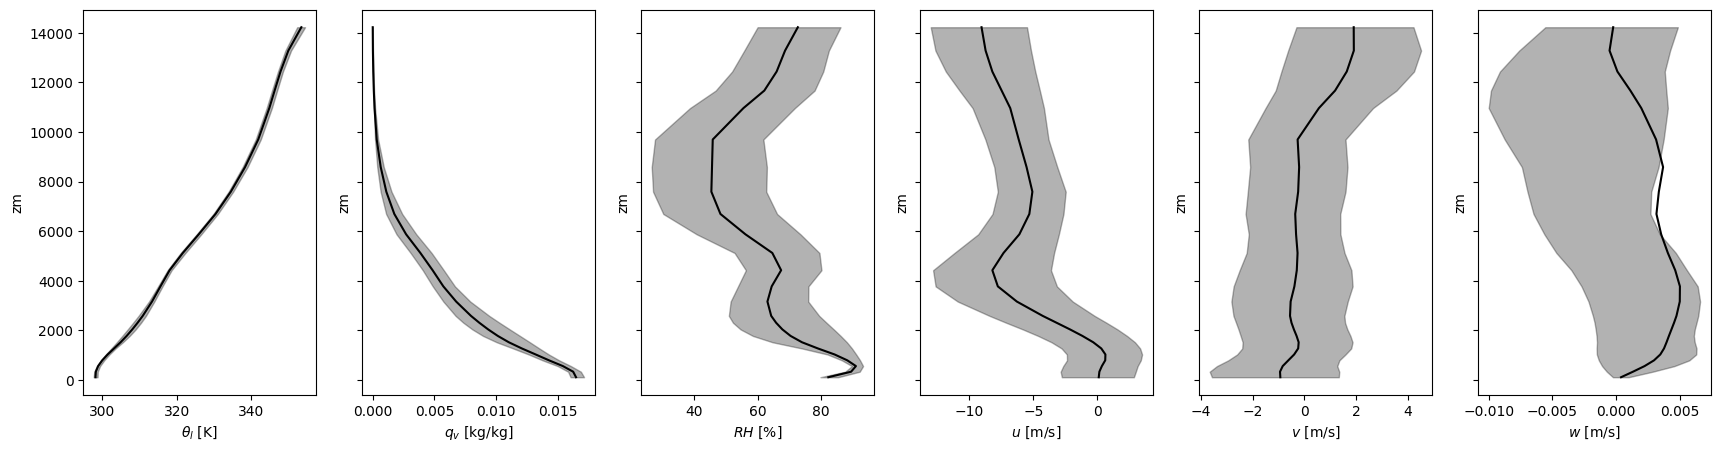

In [7]:
zmin = 0
zmax = 1.5e4 # 15 km
# zmax = 10e3
cs = ['black']

era5_env_mn_plt = era5_env_mn.sel(zm=slice(zmax,zmin))
era5_env_25_plt = era5_env_25.sel(zm=slice(zmax,zmin))
era5_env_75_plt = era5_env_75.sel(zm=slice(zmax,zmin))

fig, axs = plt.subplots(ncols=6,figsize=(21,5),sharey=True)

era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0])
axs[0].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['theta_l'], era5_env_75_plt['theta_l'], color=cs[0], alpha=0.3)
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0])
axs[1].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['q'], era5_env_75_plt['q'], color=cs[0], alpha=0.3)
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

era5_env_mn_plt['r'].plot(y='zm', ax=axs[2], color=cs[0])
axs[2].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['r'], era5_env_75_plt['r'], color=cs[0], alpha=0.3)
axs[2].set_xlabel(r'$RH$ [%]')

era5_env_mn_plt['u'].plot(y='zm', ax=axs[3], color=cs[0])
axs[3].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['u'], era5_env_75_plt['u'], color=cs[0], alpha=0.3)
axs[3].set_xlabel(r'$u$ [m/s]')

era5_env_mn_plt['v'].plot(y='zm', ax=axs[4], color=cs[0])
axs[4].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['v'], era5_env_75_plt['v'], color=cs[0], alpha=0.3)
axs[4].set_xlabel(r'$v$ [m/s]')

era5_env_mn_plt['ws'].plot(y='zm', ax=axs[5], color=cs[0])
axs[5].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['ws'], era5_env_75_plt['ws'], color=cs[0], alpha=0.3)
axs[5].set_xlabel(r'$w$ [m/s]')

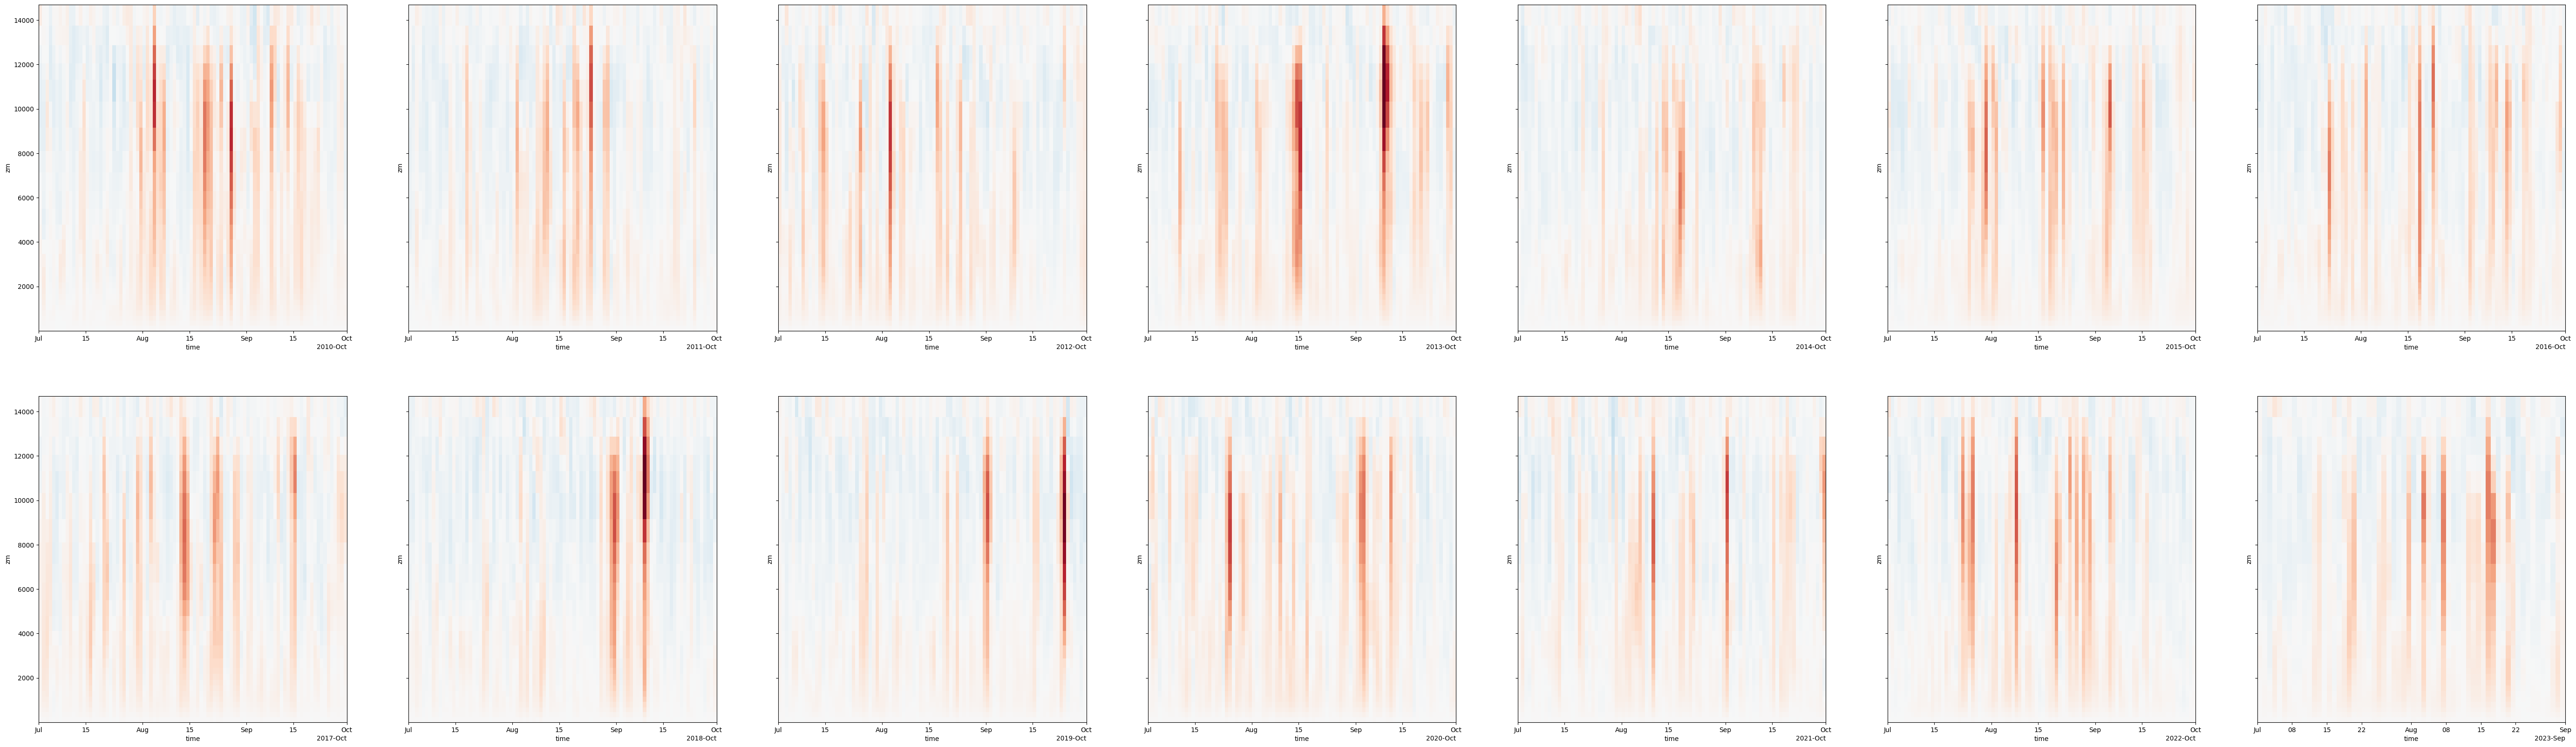

In [8]:
# Vertical motion statistics, per year, and then averaged per month (these time scales are completely arbitrary)
years = np.unique(era5_env.time.dt.year)

fig, axs = plt.subplots(ncols=len(years)//2, nrows=2, figsize=(5*len(years),20), sharey=True)
axs = axs.flatten()
for i in range(len(years)):
    wi = era5_env['ws'].mean('cell').sel(time=era5_env.time.dt.year.isin([years[i]]), zm=slice(15000,0))
    wi.plot(y='zm', ax=axs[i], vmin=-0.1, vmax=0.1, add_colorbar=False, cmap='RdBu_r')
plt.savefig(data_path+'/figures/w_600km_cabo_yearly.pdf', bbox_inches='tight')

There is lots and lots of variability on the *intra-daily* timescale. So if you want to impose a forcing that is representative of such variability, on this roughly 600 km scale, then you cannot average out that much

=> Should we do a time-height Fourier decomposition and look at some spectra?

/tmp/ipykernel_1239365/2518851802.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  wy_hat = xrft.dft(wy.drop('level'), dim=['time'], detrend='linear', window=True).compute()
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/tmp/ipykernel_1239365/2518851802.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  wy_hat = xrft.dft(wy.drop('level'), dim=['time'], detrend='linear', window=True).compute()
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/

/tmp/ipykernel_1239365/2518851802.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  wy_hat = xrft.dft(wy.drop('level'), dim=['time'], detrend='linear', window=True).compute()
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/tmp/ipykernel_1239365/2518851802.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  wy_hat = xrft.dft(wy.drop('level'), dim=['time'], detrend='linear', window=True).compute()
/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/xrft/

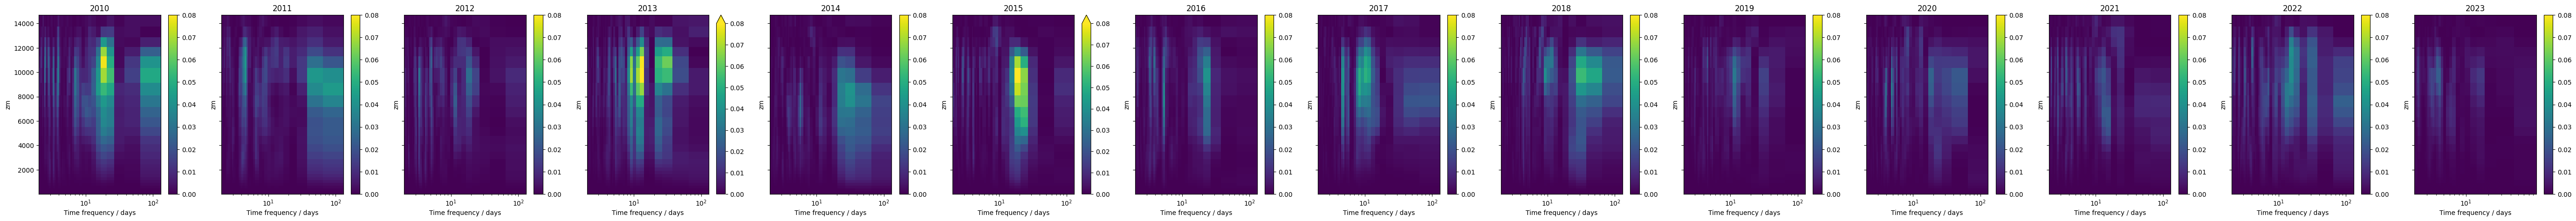

In [9]:
import xrft

fig, axs = plt.subplots(ncols=len(years), nrows=1, figsize=(5*len(years),5), sharey=True)
for i in range(len(years)):

    wy = era5_env['ws'].sel(time=era5_env.time.dt.year.isin([years[i]]), zm=slice(15000,0)).mean('cell')
    wy_hat = xrft.dft(wy.drop('level'), dim=['time'], detrend='linear', window=True).compute()
    wy_hat['t_scale'] = 1./wy_hat['freq_time']/3600/24 # Time scale of the frequencies, in days
    wy_hat = wy_hat.swap_dims({'freq_time':'t_scale'})
    (wy_hat*np.conjugate(wy_hat)).real[wy_hat.t_scale.size//2 + 1:].plot(y='zm', xscale='log', ax=axs[i], vmin=0, vmax=0.08)
    axs[i].set_title(years[i])
    axs[i].set_xlabel('Time frequency / days')

plt.savefig(data_path+'/figures/w_spectime_600km_cabo_yearly.pdf', bbox_inches='tight')
# (what*np.conjugate(bhat)).real[:,:8].mean(['time','Zl']).plot(ax=ax1)

- The time frequency of the largest vertical velocity amplitudes is around the monthly scale (10-100 days)
- It's almost always a top-heavy profile

=> It would make sense to impose such variability, and not import it! That's nice.

In [10]:
## Advection of theta_l and q_t
# 1. Vertical advection over the campaign domain is rather simple
# 2. Horizontal advection is hard. It needs to be computed, based on some assumption of where an external and an internal grid is


In [11]:
# 1. Interpolate the data onto a lat/lon grid
nlon = np.unique(era5_env['longitude']).size
nlat = np.unique(era5_env['latitude']).size

lon_min = np.min(era5_env['longitude'])
lon_max = np.max(era5_env['longitude'])

lat_min = np.min(era5_env['latitude'])
lat_max = np.max(era5_env['latitude'])

lons = np.linspace(lon_min, lon_max, nlon)
lats = np.linspace(lat_min, lat_max, nlat)

# Reset all variables to have the dimensions lat/lon (and be zero)
coords_ll = {'time':era5_env['time'],
             'zm':era5_env['zm'],
             'lon':lons,
             'lat':lats}
era5_env_ll = xr.Dataset(coords=coords_ll)
varnames = list(era5_env.keys())
for i in range(len(varnames)):
    nmi = varnames[i]
    if nmi == 'pres':
        era5_env_ll[nmi] = xr.DataArray(np.zeros([era5_env['time'].size,
                                                  era5_env['zm'].size])*np.nan,
                                        dims=('time','zm'))
    elif nmi == 'sst':
        era5_env_ll[nmi] = xr.DataArray(np.zeros([era5_env['time'].size,
                                                  lons.size,
                                                  lats.size])*np.nan,
                                        dims=('time','lon','lat'))
    else:
        era5_env_ll[nmi] = xr.DataArray(np.zeros([era5_env['time'].size,
                                                  era5_env['zm'].size,
                                                  lons.size,
                                                  lats.size])*np.nan,
                                        dims=('time', 'zm', 'lon', 'lat'))

# Try looping over cell again and just getting what is there
idx = era5_env['cell']
for i in range(idx.size):
    loni = idx[i]['longitude']
    lati = idx[i]['latitude']
    
    # Find the closest point in the meshgrid spanned by lats / lons to this (loni, lati)
    ilon = np.argmin(np.abs(loni.data - lons))
    ilat = np.argmin(np.abs(lati.data - lats))
        
    for j in range(len(varnames)):
        nmj = varnames[j]
        if nmj == 'pres':
            era5_env_ll[nmj][:,:] = era5_env[nmj]
        elif nmj == 'sst':
            era5_env_ll[nmj][:,ilon,ilat] = era5_env[nmj].isel(cell=i)
        else:
            era5_env_ll[nmj][:,:,ilon,ilat] = era5_env[nmj].isel(cell=i)

era5_env_ll = era5_env_ll.coarsen({'lon':2,'lat':2},boundary='trim').mean()
era5_env_ll

<xarray.Dataset> Size: 358MB
Dimensions:    (time: 1258, zm: 29, lon: 8, lat: 9)
Coordinates:
  * time       (time) datetime64[ns] 10kB 2010-07-01T12:00:00 ... 2023-08-31T...
    level      (zm) int64 232B 50 70 100 125 150 175 ... 900 925 950 975 1000
  * zm         (zm) float32 116B 2.069e+04 1.866e+04 1.659e+04 ... 336.6 114.2
  * lon        (lon) float64 64B 331.3 332.1 332.8 333.5 334.2 334.9 335.6 336.3
  * lat        (lat) float64 72B 9.444 10.05 10.67 11.28 ... 13.11 13.72 14.33
Data variables: (12/19)
    z          (time, zm, lon, lat) float64 21MB 2.03e+05 2.03e+05 ... 922.8
    q          (time, zm, lon, lat) float64 21MB 2.394e-06 2.406e-06 ... 0.01803
    r          (time, zm, lon, lat) float64 21MB 2.921 3.008 ... 85.05 84.33
    clwc       (time, zm, lon, lat) float64 21MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    t          (time, zm, lon, lat) float64 21MB 209.8 209.6 ... 299.3 299.4
    u          (time, zm, lon, lat) float64 21MB -22.89 -23.01 ... 7.472 7.458
    ...         ...
    theta_l    (time, zm, lon, lat) float64 21MB 493.7 493.4 ... 299.3 299.4
    theta_l_s  (time, zm, lon, lat) float64 21MB 707.9 708.0 ... 302.1 302.0
    rho        (time, zm, lon, lat) float64 21MB 0.08304 0.08309 ... 1.164 1.164
    ws         (time, zm, lon, lat) float64 21MB 0.01385 0.01545 ... 0.0001899
    U          (time, zm, lon, lat) float64 21MB 22.9 23.03 ... 9.822 9.595
    qs         (time, zm, lon, lat) float64 21MB 8.195e-05 7.997e-05 ... 0.02138

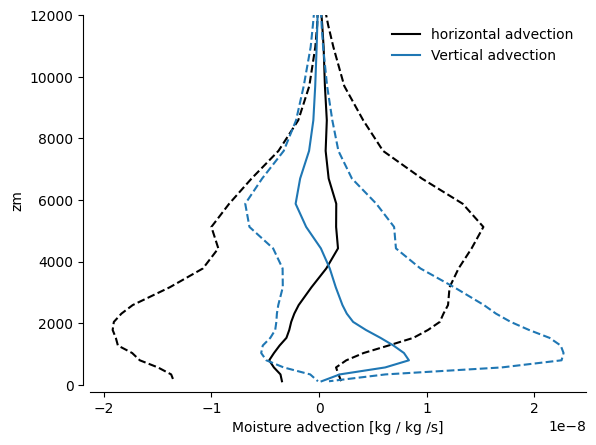

In [12]:
# Estimate the advective tendencies on these grids, and average them over a cutout

# Moisture
era5_env_ll['q_adv_h'] = (-era5_env_ll['u'] * era5_env_ll['q'].differentiate('lon')
                          -era5_env_ll['v'] * era5_env_ll['q'].differentiate('lat')) / 1e5 # lat/lon => m

era5_env_ll['q_adv_v'] = -era5_env_ll['ws'] * era5_env_ll['q'].differentiate('zm')

# Horizontal advection envelope
era5_env_ll['q_adv_h'].median(['time','lon','lat']).plot(y='zm', c='k', label='horizontal advection')
era5_env_ll['q_adv_h'].quantile(0.25, dim=['time','lon','lat']).plot(y='zm', c='k', linestyle='--')
era5_env_ll['q_adv_h'].quantile(0.75, dim=['time','lon','lat']).plot(y='zm', c='k', linestyle='--')

# Vertical advection envelope
era5_env_ll['q_adv_v'].median(['time','lon','lat']).plot(y='zm',  c='C0', label='Vertical advection')
era5_env_ll['q_adv_v'].quantile(0.25, dim=['time','lon','lat']).plot(y='zm', c='C0', linestyle='--')
era5_env_ll['q_adv_v'].quantile(0.75, dim=['time','lon','lat']).plot(y='zm', c='C0', linestyle='--')

plt.ylim(0,12e3)
plt.legend(frameon=False)
plt.title('')
plt.xlabel('Moisture advection [kg / kg /s]')

sns.despine(offset=5)

plt.savefig(data_path+'/figures/advection_q.pdf', bbox_inches='tight')

### Fit simple profiles using the shallow botany functions

<xarray.DataArray 'theta_l' ()> Size: 8B
array(298.26407752)
Coordinates:
    level    int64 8B 1000
    zm       float32 4B 114.2

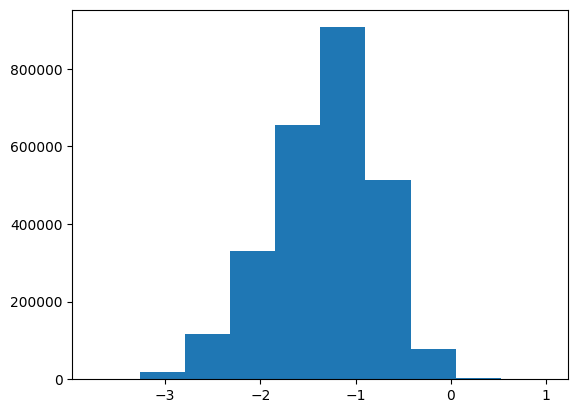

In [13]:
# Can we use the same free parameters as we're used to?

# theta difference between surface and first layer
thl0 = era5_env_ll['theta_l'].isel(zm=-1)
thls = era5_env_ll['sst']*(1e5/era5_env_ll['sp'])**(2./7)
dthls = thl0 - thls
dthls.plot.hist()
dthls.mean()

thl0.mean()
# mixed layer height

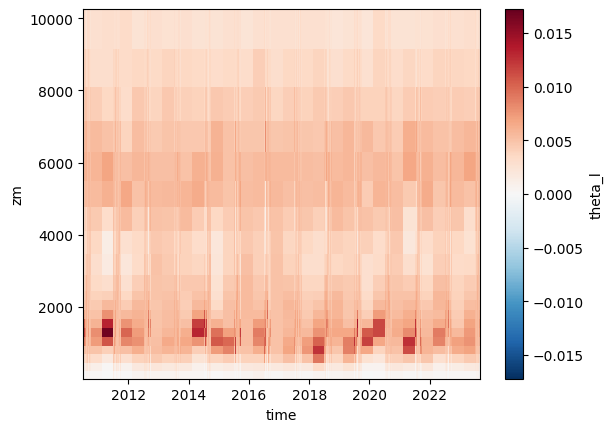

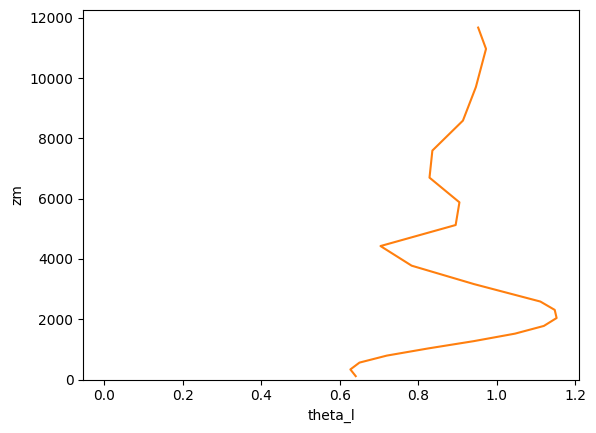

In [14]:
## Is there actually any variability in the FT lapse rate?
gaml = era5_env_ll['theta_l'].mean(['lon','lat']).differentiate('zm')
gaml.sel(zm=slice(1e4,0)).plot(x='time')

# Bulk lapse rate
zsel = np.array([9699.943,2587.7488])
gaml_bulk = era5_env_ll['theta_l'].mean(['lon','lat']).sel(zm=zsel).diff('zm')/np.diff(zsel)

plt.figure()
gaml_bulk.plot.hist()
# gaml_binned = gaml.to_dataset().groupby_bins('theta_l', bins=20)#.mean()
# gaml_binned['theta_l'].plot

# Variability in theta_l itself at the lower point
# plt.figure()
thlft0 = era5_env_ll['theta_l'].mean(['lon','lat']).sel(zm=2500,method='nearest')
# thlft0.quantile(0.75) - thlft0.quantile(0.25)
thl_std = era5_env_ll['theta_l'].mean(['lon','lat']).std('time').sel(zm=slice(1.2e4,0)).plot(y='zm')

## No, there is not much

In [15]:
## Functions
import thermo

# Linear profile, fixed gradient (shear)
def linu(z, u0, dudz=0.00222):
    return u0 + dudz*z

# Linear profile, no fixed shear
def linv(z, u0, dudz):
    return u0 + dudz*z

# Linear profile, no fixed shear, and African Easterly Jet model
def linv_aej(z, u0, dudz, ujet, href=4000, hsca=6000):
    u = u0 + dudz*z
    aej = -ujet*np.cos(np.pi*(z - href)/hsca)
    aej[z<=href-0.5*hsca] = 0
    aej[z>=href+0.5*hsca] = 0
    return u + aej

# Linear profile with mixed layer, with mixed layer value based on surface value (u0) minus offset
def linml(z, u0, dudz, du0=1.25, zml=500):
    u = np.zeros(z.shape)
    u[z<=zml] = u0 - du0 # Positive offsets are reductions w.r.t surface
    u[z>zml] = u0 - du0 + (z[z>zml] - zml)*dudz
    return u

# Exponential decay with mixed layer, where qt0 is set at zml
def exp(z, u0, u_lambda, zml=500):
    u = u0 * np.exp(-(z-zml) / u_lambda)
    if type(u0) == float:
        u[z<=zml] = u0
    elif u0.ndim < 2:
        u[z<=zml] = u0
    elif u0.ndim == 2:
        z  = z .reshape(z.size)
        u0 = u0.reshape(u0.size)
        for i in range(u0.size):
            u[z<=zml,i] = u0[i]
    else:
        print('Dimension of input u0 not supported, mixed layer not added')
    return u

# First mode of vertical velocity - exponential decay with Hadley cell
def w_0(z, w0, hw0):
    psi0 = (1-np.exp(-z/hw0))
    return psi0*w0

# Second mode of vertical velocity - mesoscale circulation
def w_1(z, w1, hw1):
    psi1 = np.sin(2.*np.pi/hw1*z)
    psi1[z>hw1] = 0.
    return psi1*w1

# Sum of first and second modes of vertical velocity - with fixed w0, hw0, hw1
def w_01(z, w1, w0=-0.0045, hw0=2500, hw1=5300):
    return w_0(z, w0, hw0) + w_1(z, w1, hw1)

# Compute rh for profile
def rhProf(thl0, dthldz, qt0, qt_lambda, z, pres, du=1.25, zml=500):
    thl = linml(z, thl0, dthldz, du0=du, zml=zml)
    qt  = exp(z, qt0 , qt_lambda, zml=zml)
    T, ql = thermo.T_and_ql(thl, qt, pres)    
    qs = thermo.qsatur(T,pres)
    qv = qt-ql
    return 100*qv/qs

# Relaxation towards a reference profile over a certain height
def relax(z, prof_ideal, prof_ref, href=9e3, hsca=3e3):
    # Assumes 1D input
    if prof_ideal.size != prof_ref.size:
        prof_ref = prof_ref.interp(zm=z,kwargs={"fill_value": "extrapolate"})

    du = prof_ideal - prof_ref

    # Subtract difference from the original profile, scaled by a function which goes
    # from 0->1 over a height hsca centered around href
    fac = 0.5 - 0.5*np.cos(np.pi*(z - (href-0.5*hsca))/hsca)
    fac[z<=href-0.5*hsca] = 0
    fac[z>=href+0.5*hsca] = 1

    return prof_ideal - du*fac

In [16]:
## Loop over all profiles
from scipy.optimize import curve_fit

calc_fits = False

# Selection height range
zfitmin = 0
zfitmax = 8e3

var_fits = ['thls',
            'dthldz',
            'qt0',
            'hqt',
            'u0',
            'dudz',
            'ujet',
            'v0',
            'dvdz',
            'w1',
            'vthls',
            'vdthldz',
            'vqt0',
            'vhqt',
            'vu0',
            'vdudz',
            'vujet',
            'vv0',
            'vdvdz',
            'vw1']

era5_env_ll_mn = era5_env_ll.mean(['lon', 'lat'])

if calc_fits:
    ds_fits = xr.Dataset(coords={'time':era5_env_ll.coords['time'],
                                 'zm':era5_env_ll.coords['zm']})
    for i in range(len(var_fits)):
        ds_fits[var_fits[i]] = xr.DataArray(np.zeros(ds_fits.coords['time'].size)*np.nan, coords={'time':ds_fits.time}, dims=('time'))

    ds_fits['theta_l'] = xr.DataArray(np.nan,coords={'time':ds_fits.time,'zm':ds_fits.zm}, dims=('time','zm'))
    ds_fits['qt'] = xr.DataArray(np.nan,coords={'time':ds_fits.time,'zm':ds_fits.zm}, dims=('time','zm'))
    ds_fits['rh'] = xr.DataArray(np.nan,coords={'time':ds_fits.time,'zm':ds_fits.zm}, dims=('time','zm'))
    ds_fits['u'] = xr.DataArray(np.nan,coords={'time':ds_fits.time,'zm':ds_fits.zm}, dims=('time','zm'))
    ds_fits['v'] = xr.DataArray(np.nan,coords={'time':ds_fits.time,'zm':ds_fits.zm}, dims=('time','zm'))  

    ind = 0
    zfit = era5_env_ll_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')
    dsfit = era5_env_ll_mn.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
    for i in range(len(era5_env_ll.time)):

        # Fit curves
        [thls,dthldz], pcth = curve_fit(linml,
                                        zfit, 
                                        dsfit['theta_l'].isel(time=i), 
                                        p0=[300,0.004])

        [qt0,hqt], pcqt = curve_fit(exp,
                                    zfit,
                                    dsfit['q'].isel(time=i), # Assuming the environment is never sat.
                                    p0=[0.016,1500])

        [u0,dudz,ujet], pcu = curve_fit(linv_aej,
                                       zfit,
                                       dsfit['u'].isel(time=i),
                                       p0=[-10, 0.00222, 6])

        [v0,dvdz], pcv = curve_fit(linv,
                                   zfit,
                                   dsfit['v'].isel(time=i),
                                   p0=[0,0])

#         try:
#             # Exponential+first wave mode of prescribed depth -> Almost always breaks
#             w1, pcw = curve_fit(w_01,
#                                 zfit,
#                                 dsfit['w'].isel(time=i),
#                                 p0=-0.0025)
#         except:
#             print('Error raised by curvefit, setting nans')
#             w1 = np.nan
#             pcw = np.nan

        # Write to ds (along with profile it produces)
        ds_fits['thls'][i] = thls
        ds_fits['dthldz'][i] = dthldz
        ds_fits['qt0'][i] = qt0
        ds_fits['hqt'][i] = hqt
        ds_fits['u0'][i] = u0
        ds_fits['dudz'][i] = dudz
        ds_fits['v0'][i] = v0
        ds_fits['dvdz'][i] = dvdz
        ds_fits['qt0'][i] = qt0
#         ds_fits['w1'][i] = w1
        ds_fits['vthls'][i] = pcth[0,0]
        ds_fits['vdthldz'][i] = pcth[1,1]
        ds_fits['vqt0'][i] = pcqt[0,0]
        ds_fits['vhqt'][i] = pcqt[1,1]
        ds_fits['vu0'][i] = pcu[0,0]
        ds_fits['vu0'][i] = pcu[0,0]
        ds_fits['vdudz'][i] = pcu[1,1]
        ds_fits['vv0'][i] = pcv[0,0]
        ds_fits['vdvdz'][i] = pcv[1,1]
#         ds_fits['vw1'][i] = pcw

        ds_fits['theta_l'][i,:] = linml(ds_fits['zm'], thls, dthldz)
        ds_fits['qt'][i,:] = exp(ds_fits['zm'], qt0, hqt)
#         ds_fits['rh'][i,:] = rhProf(thls, dthldz, qt0, hqt, ds_fits['zm'], era5_env_ll_mn['pres'].isel(time=0))
        ds_fits['u'][i,:] = linv_aej(ds_fits['zm'], u0, dudz, ujet)
        ds_fits['v'][i,:] = linv(ds_fits['zm'], v0, dvdz)

        ind += 1

        if ind%100 == 0:
            print('Done', ind, ' / ', ds_fits.time.size)
    ds_fits.to_netcdf(data_path+'/simpleparams-botany-deep.nc',mode='w')
else:
    ds_fits = xr.open_dataset(data_path+'/simpleparams-botany-deep.nc')
ds_fits

dse = era5_env_ll.mean(['time','lon','lat'])
for i in range(ds_fits.time.size):
    if ind%100 == 0:
        print('Done', i, ' / ', ds_fits.time.size)
    ds_fits['theta_l'][i,:] = relax(ds_fits['zm'], ds_fits['theta_l'][i,:], dse['theta_l'])
    ds_fits['qt'][i,:] = relax(ds_fits['zm'], ds_fits['qt'][i,:], dse['q'])
    ds_fits['u'][i,:] = relax(ds_fits['zm'], ds_fits['u'][i,:], dse['u'])
    ds_fits['v'][i,:] = relax(ds_fits['zm'], ds_fits['v'][i,:], dse['v'])
    

NameError: name 'ind' is not defined

In [ ]:
# era5_env_mn.to_netcdf('era5_env_mn.nc', 'w')

In [ ]:
zmin = 0
zmax = 1.5e4 # 15 km
# zmax = 4e3
cs = ['black', 'C1']

era5_env_mn_plt = era5_env_mn.sel(zm=slice(zmax,zmin))
fits_plt = ds_fits.sel(zm=slice(zmax,zmin)).mean('time')

fig, axs = plt.subplots(ncols=5,figsize=(17.5,5),sharey=True)

era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0])
# axs[0].plot(thlmn, ds_fits['zm'], color=cs[1])
fits_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[1])
# axs[0].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['theta_l'], era5_env_75_plt['theta_l'], color=cs[0], alpha=0.3)
axs[0].set_xlabel(r'$\theta_l$ [K]')

era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0])
fits_plt['qt'].plot(y='zm', ax=axs[1], color=cs[1])
# axs[1].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['q'], era5_env_75_plt['q'], color=cs[0], alpha=0.3)
axs[1].set_xlabel(r'$q_v$ [kg/kg]')

# era5_env_mn_plt['r'].plot(y='zm', ax=axs[1], color=cs[0])
# fits_plt['rh'].plot(y='zm', ax=axs[1], color=cs[1])
# axs[2].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['r'], era5_env_75_plt['r'], color=cs[0], alpha=0.3)
# axs[2].set_xlabel(r'$RH$ [%]')

era5_env_mn_plt['u'].plot(y='zm', ax=axs[3], color=cs[0])
fits_plt['u'].plot(y='zm', ax=axs[3], color=cs[1])
# axs[3].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['u'], era5_env_75_plt['u'], color=cs[0], alpha=0.3)
axs[3].set_xlabel(r'$u$ [m/s]')

era5_env_mn_plt['v'].plot(y='zm', ax=axs[4], color=cs[0])
fits_plt['v'].plot(y='zm', ax=axs[4], color=cs[1])
# axs[4].fill_betweenx(era5_env_mn_plt['zm'], era5_env_25_plt['v'], era5_env_75_plt['v'], color=cs[0], alpha=0.3)
axs[4].set_xlabel(r'$v$ [m/s]')

### Tests with the mean profile
Note the mid-tropospheric humidity and lapse rate feature - the second trade inversion associated with the detrainment level of cumuli congestus. This is a feature we'd expect the LES to recreate (but we don't know if it can and how long it would take). So for the functional forms, we could start by assuming it's not there, and hope the LES creates it on its own.

To avoid the upper level relative humidity peak from being overly influenced by choices in the free parameters, we can relax them back to the climatological mean profiles.

In [ ]:
era5_env_mn_fit = era5_env_mn.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
zfit = era5_env_ll_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

[thls,dthldz], pcth = curve_fit(linml,
                                zfit, 
                                era5_env_mn_fit['theta_l'], 
                                p0=[300,0.004])

[qt0,hqt], pcqt = curve_fit(exp,
                            zfit,
                            era5_env_mn_fit['q'],
                            p0=[0.016,1500])

[u0,dudz,ujet], pcu = curve_fit(linv_aej,
                           zfit,
                           era5_env_mn_fit['u'],
                           p0=[-10, 0.00222, 6])

[v0,dvdz], pcv = curve_fit(linv,
                           zfit,
                           era5_env_mn_fit['v'],
                           p0=[0,0])



In [ ]:


# zfit = era5_env_ll_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')
# href=4000
# hsca=2000
# aej = np.cos(np.pi*(zfit - href)/hsca)
# aej[zfit<=href-0.5*hsca] = 0
# aej[zfit>=href+0.5*hsca] = 0

# plt.plot(aej,zfit)

In [ ]:
# Using the mean fitted profile
thl = linml(ds_fits['zm'], thls, dthldz)
qt = exp(ds_fits['zm'], qt0, hqt)
u = linv_aej(ds_fits['zm'], u0, dudz, ujet)
v = linv(ds_fits['zm'], v0, dvdz)

# Using the mean over all fitted profiles
fits_test = ds_fits.mean('time')
# thl = fits_test['theta_l'].data
# qt = fits_test['qt'].data

dse = era5_env_ll.mean(['time','lon','lat'])

qt = relax(ds_fits['zm'], qt, dse['q'])
thl = relax(ds_fits['zm'], thl, dse['theta_l']).data
u = relax(ds_fits['zm'], u, dse['u']).data


T, ql = thermo.T_and_ql(thl, qt, dse['pres'].data)

plt.plot(T, fits_test['zm'])
dse['t'].plot(y='zm')

# plt.figure()
# plt.plot(ql, fits_test['zm'])

qs = thermo.qsatur(T,dse['pres'].data)
qv = qt - ql
rh = qv/qs*100

Te, qle = thermo.T_and_ql(dse['theta_l'].data, dse['q'].data+dse['clwc'].data, dse['pres'].data) 
qse = thermo.qsatur(Te,dse['pres'].data)
rhe = dse['q']/qse*100

plt.figure()
plt.plot(qv, fits_test['zm'])
dse['q'].plot(y='zm')

plt.figure()
plt.plot(rh, fits_test['zm'])
plt.plot(rhe, fits_test['zm'])

plt.figure()
plt.plot(u,fits_test['zm'])
dse['u'].plot(y='zm')

I'm also not convinced about the variability we should impose in the lapse rate. It's small, and WTG really holds throughout the troposphere (<1 K). The larger variability is found near the surface, and so it's really LTS underneath a constant FT-temperature profile that governs any variability, given an SST.